### Imports

In [2]:
import numpy as np
import matplotlib.pylab as plt

import pandas as pd

import hist
from hist import Hist

# To read file names using the OS (operating system)
import glob
import os

# Simulation-based background estimation

There are Standard Model processes that can produce the same final state objects and mimic the Z' signal. Selection criteria have been chosen so that the kinematics differ from the signal, but it is not possible to completely eliminate all Standard Model processes. Therefore, it is necessary to estimate how much of the remaining collision data can be explained by these background processes.

Essentially, simulation datasets modeling the backgrounds will be utilized. All these contributions are summed to check if there is an excess that could be explained by the signal hypothesis, in this case, Z'.

The focus will be on four physical processes that might mimic the signal and are identified as possible backgrounds:

- Production of a top-quark pair that decays semileptonically
- Production of a top-quark pair that decays hadronically
- Production of a top-quark pair that decays leptonically
- Production of W bosons in association with jets, where the W bosons decay leptonically

Throughout the analysis, `collision` refers to the data, while the other names correspond to the signal MC and background MC samples.

* Signal MC datasets
  * `signal_M2000`
* Background MC datasets
  * `ttsemilep`
  * `tthadronic`
  * `ttleptonic`
  * `Wjets`

In [3]:
# Take a look in the directory
!ls processed_files | tail -20

OUTPUT_Wjets_B6C226A2-35AA-2A4D-8911-3A1FAB336DD9.csv
OUTPUT_Wjets_B73BE8B0-3240-A44B-9731-EFAD156B9668.csv
OUTPUT_Wjets_B771B076-AECE-AF42-B780-2C3192BC4DE5.csv
OUTPUT_Wjets_BB2D42DC-ECA1-6B46-8A74-F597A314E051.csv
OUTPUT_Wjets_BE97AC18-0F73-C645-8AA2-66793B308D1B.csv
OUTPUT_Wjets_BEDECBF7-AB16-314C-8811-AB5D27231DB6.csv
OUTPUT_Wjets_BF4971FC-B933-A449-BFF1-5F8007D51EEF.csv
OUTPUT_Wjets_C10A9933-1E22-5D40-B968-89520B795DFB.csv
OUTPUT_Wjets_C59AF067-3B3E-D94B-84BA-987748C30221.csv
OUTPUT_Wjets_CC80A34F-10EC-9B43-A56B-3DEE96459E7F.csv
OUTPUT_Wjets_DDCB723A-3704-5345-AAD3-EF2479209ABE.csv
OUTPUT_Wjets_DDCE98B4-9142-D041-A3BF-1F81DECC09D2.csv
OUTPUT_Wjets_E1690230-A2B7-014B-944F-94109B6AED08.csv
OUTPUT_Wjets_EA7F0AF0-D312-174A-B43A-2ECB60C0055F.csv
OUTPUT_Wjets_ED909592-EDA1-7D48-9749-89E23280C916.csv
OUTPUT_Wjets_F040E4B7-FCB0-634E-87BF-CE9894216671.csv
OUTPUT_Wjets_F0547BE9-147E-E64A-BC58-C715936EA122.csv
OUTPUT_Wjets_F33E5121-B08C-D545-86E7-6A095E901009.csv
OUTPUT_Wjets_F5E2630A-AFE2-4

In [4]:
# How many files are in the `processed_files` directory
!ls processed_files | wc -l

555


In [5]:
# Open one of the collision files
df_col = pd.read_csv('processed_files/OUTPUT_collision_0107961B-4308-F845-8F96-E14622BBA484.csv')

# Display the first 5 rows
df_col.head(5)

mtt      mu_pt  mu_abseta  pileup  weight    nevents  N_gen  \
0   807.198446   82.50003   1.199951  -999.0  -999.0  2383660.0 -999.0   
1   671.563515   82.50003   1.199951  -999.0  -999.0  2383660.0 -999.0   
2  2119.381227   75.99521   1.057129  -999.0  -999.0  2383660.0 -999.0   
3  1155.580922   75.99521   1.057129  -999.0  -999.0  2383660.0 -999.0   
4  1229.805844  174.02802   1.239746  -999.0  -999.0  2383660.0 -999.0   

   gw_pos  gw_neg  
0  -999.0  -999.0  
1  -999.0  -999.0  
2  -999.0  -999.0  
3  -999.0  -999.0  
4  -999.0  -999.0

In [6]:
# Open one of the simulation files
df_sim = pd.read_csv('processed_files/OUTPUT_tthadronic_009086DB-1E42-7545-9A35-1433EC89D04B.csv')

# Display the first 5 rows
df_sim.head(5)

mtt      mu_pt  mu_abseta  pileup      weight    nevents  \
0   833.524409  149.55150   0.109131    21.0  316.466003  1344000.0   
1   933.524622  152.53360   0.540527    19.0  316.466003  1344000.0   
2  1017.235309  157.52630   1.589844    25.0  316.466003  1344000.0   
3   812.874216  157.52630   1.589844    25.0  316.466003  1344000.0   
4   447.547154  102.70946   0.311707    19.0  316.466003  1344000.0   

       N_gen     gw_pos  gw_neg  
0  1332932.0  1338466.0  5534.0  
1  1332932.0  1338466.0  5534.0  
2  1332932.0  1338466.0  5534.0  
3  1332932.0  1338466.0  5534.0  
4  1332932.0  1338466.0  5534.0

To avoid working with 555 individual files, we will merge them, resulting in a single file per dataset.

In [7]:
# The list of dataset names to be processed.
datasets = ['collision', 'signal_M2000', 'ttsemilep', 'tthadronic', 'ttleptonic', 'Wjets']

collision_datasets = datasets[0]
signal_datasets = datasets[1]
background_datasets = datasets[2:]

# Loop through each dataset in the list.
for dataset in datasets:
    # Initialize variables to store cumulative values.
    N_gen = 0
    nevents = 0
    gw_pos = 0
    gw_neg = 0
    # A flag to indicate if the current dataset is a collision dataset.
    IS_COLLISION = False

    path = r'./'
    all_files = glob.glob(os.path.join(path, f"processed_files/OUTPUT_{dataset}*.csv"))
    print(f"Processing {len(all_files)} files in {dataset} ")

    list_of_dataframes = []
    for filename in all_files:
        if filename.find('collision') >= 0:
            IS_COLLISION = True
        df = pd.read_csv(filename, index_col=None, header=0)
        list_of_dataframes.append(df)

        # If the DataFrame is not empty, accumulate the first row values of certain columns.
        if len(df) > 0:
            N_gen += df['N_gen'][0]
            nevents += df['nevents'][0]
            gw_pos += df['gw_pos'][0]
            gw_neg += df['gw_neg'][0]

    # If the dataset is a collision dataset, set specific values to -999 to indicate invalid data.
    if IS_COLLISION:
        N_gen = -999
        gw_pos = -999
        gw_neg = -999

    # Concatenate all DataFrames in the list into a single DataFrame.
    df = pd.concat(list_of_dataframes, axis=0, ignore_index=True)
    df['N_gen'] = N_gen
    df['nevents'] = nevents
    df['gw_pos'] = gw_pos
    df['gw_neg'] = gw_neg

    df.to_csv(f'SUMMED_{dataset}.csv')

Processing 151 files in collision 


/tmp/ipykernel_3407/1566159408.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(list_of_dataframes, axis=0, ignore_index=True)
/tmp/ipykernel_3407/1566159408.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(list_of_dataframes, axis=0, ignore_index=True)


Processing 4 files in signal_M2000 
Processing 138 files in ttsemilep 
Processing 146 files in tthadronic 


/tmp/ipykernel_3407/1566159408.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(list_of_dataframes, axis=0, ignore_index=True)


Processing 48 files in ttleptonic 
Processing 68 files in Wjets 


/tmp/ipykernel_3407/1566159408.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat(list_of_dataframes, axis=0, ignore_index=True)


In [8]:
!ls -ltr

total 21764
drwxr-xr-x 2 acer acer    61440 jul 30 04:25 processed_files
-rw-rw-r-- 1 acer acer   363891 ago  9 11:06 background_modeling_lesson.ipynb
-rw-rw-r-- 1 acer acer   463100 ago  9 11:07 SUMMED_collision.csv
-rw-rw-r-- 1 acer acer  4071960 ago  9 11:07 SUMMED_signal_M2000.csv
-rw-rw-r-- 1 acer acer 15457301 ago  9 11:07 SUMMED_ttsemilep.csv
-rw-rw-r-- 1 acer acer    90802 ago  9 11:07 SUMMED_tthadronic.csv
-rw-rw-r-- 1 acer acer  1755344 ago  9 11:07 SUMMED_ttleptonic.csv
-rw-rw-r-- 1 acer acer     1895 ago  9 11:07 SUMMED_Wjets.csv


In [9]:
!wc -l SUMMED*csv

    5495 SUMMED_collision.csv
   48239 SUMMED_signal_M2000.csv
     818 SUMMED_tthadronic.csv
   16135 SUMMED_ttleptonic.csv
  137081 SUMMED_ttsemilep.csv
      20 SUMMED_Wjets.csv
  207788 total


In [10]:
!head SUMMED_collision.csv

,mtt,mu_pt,mu_abseta,pileup,weight,nevents,N_gen,gw_pos,gw_neg
0,1224.4791081852393,77.26053,1.5141602,-999.0,-999.0,322617472.0,-999,-999,-999
1,837.4450825549179,80.53929,0.6542969,-999.0,-999.0,322617472.0,-999,-999,-999
2,790.134117650452,80.53929,0.6542969,-999.0,-999.0,322617472.0,-999,-999,-999
3,720.643079701126,80.53929,0.6542969,-999.0,-999.0,322617472.0,-999,-999,-999
4,1875.0322362805605,213.58112,0.15115356,-999.0,-999.0,322617472.0,-999,-999,-999
5,1706.2484689965538,213.58112,0.15115356,-999.0,-999.0,322617472.0,-999,-999,-999
6,1607.9886386044184,184.02084,1.0939941,-999.0,-999.0,322617472.0,-999,-999,-999
7,1212.0693457501486,308.01816,0.45391846,-999.0,-999.0,322617472.0,-999,-999,-999
8,1487.2809148586955,280.2566,0.93151855,-999.0,-999.0,322617472.0,-999,-999,-999


In [12]:
#Read all ".csv" files as dataframes and store them in a dictionary. 
#Extract the "N_gen" variable from each file and include it in the dictionary.
    
data = {}

for dataset in datasets:
    df = pd.read_csv(f'SUMMED_{dataset}.csv')
    
    N_gen = df['N_gen'][0]
    
    data[dataset] = {'df':df, 'N_gen': N_gen}

In [13]:
data

{'collision': {'df':       Unnamed: 0          mtt      mu_pt  mu_abseta  pileup  weight  \
  0              0  1224.479108   77.26053   1.514160  -999.0  -999.0   
  1              1   837.445083   80.53929   0.654297  -999.0  -999.0   
  2              2   790.134118   80.53929   0.654297  -999.0  -999.0   
  3              3   720.643080   80.53929   0.654297  -999.0  -999.0   
  4              4  1875.032236  213.58112   0.151154  -999.0  -999.0   
  ...          ...          ...        ...        ...     ...     ...   
  5489        5489   468.009508  120.39081   0.891968  -999.0  -999.0   
  5490        5490   798.040989   81.86283   0.181458  -999.0  -999.0   
  5491        5491   658.510760   81.86283   0.181458  -999.0  -999.0   
  5492        5492  1027.776333   81.86283   0.181458  -999.0  -999.0   
  5493        5493  1969.833314  209.80046   1.252197  -999.0  -999.0   
  
            nevents  N_gen  gw_pos  gw_neg  
  0     322617472.0   -999    -999    -999  
  1     3226

In [14]:
# Subsets of the dictionary provide access to individual datasets.
data['ttsemilep']['df']

Unnamed: 0          mtt       mu_pt  mu_abseta  pileup      weight  \
0                0  1280.353541   88.970825   0.400391    25.0  303.358002   
1                1  1284.581874   88.970825   0.400391    25.0  303.358002   
2                2   871.299322  124.265816   1.337646    26.0  303.358002   
3                3   722.109298  124.265816   1.337646    26.0  303.358002   
4                4   779.627780  124.265816   1.337646    26.0  303.358002   
...            ...          ...         ...        ...     ...         ...   
137075      137075  1388.749801  224.071660   0.607788    15.0  303.358002   
137076      137076  1700.865730  224.071660   0.607788    15.0  303.358002   
137077      137077  1768.829172  124.281850   0.740601    29.0  303.358002   
137078      137078   811.764461  124.281850   0.740601    29.0  303.358002   
137079      137079  1168.894162   59.841354   1.116455    23.0  303.358002   

            nevents        N_gen       gw_pos    gw_neg  
0       144722000.0  143553998.0  144137999.0  584001.0  
1       144722000.0  143553998.0  144137999.0  584001.0  
2       144722000.0  143553998.0  144137999.0  584001.0  
3       144722000.0  143553998.0  144137999.0  584001.0  
4       144722000.0  143553998.0  144137999.0  584001.0  
...             ...          ...          ...       ...  
137075  144722000.0  143553998.0  144137999.0  584001.0  
137076  144722000.0  143553998.0  144137999.0  584001.0  
137077  144722000.0  143553998.0  144137999.0  584001.0  
137078  144722000.0  143553998.0  144137999.0  584001.0  
137079  144722000.0  143553998.0  144137999.0  584001.0  

[137080 rows x 10 columns]

Compare the total number of events (`N_gen` or `nevents`) with the official number on the Open Data portal:

[Open Data Portal](https://opendata.cern.ch/record/67993)

Small differences are typically due to imperfections in file processing.

In [18]:
data['ttsemilep']['N_gen']

143553998.0

An error occurred when combining all the Wjets files. Some NanoAOD files had no surviving events, resulting in empty .csv files where the original number of generated events was not recorded.

To correct this, set the value using information from the Open Data Portal:

[Open Data Portal](https://opendata.cern.ch/record/69747)

In [16]:
data['Wjets']['N_gen'] = 80958227
data['Wjets']['df']['N_gen'] = 80958227

data['Wjets']['N_gen']

80958227

Now, a quick plot of all the different datasets can be created.

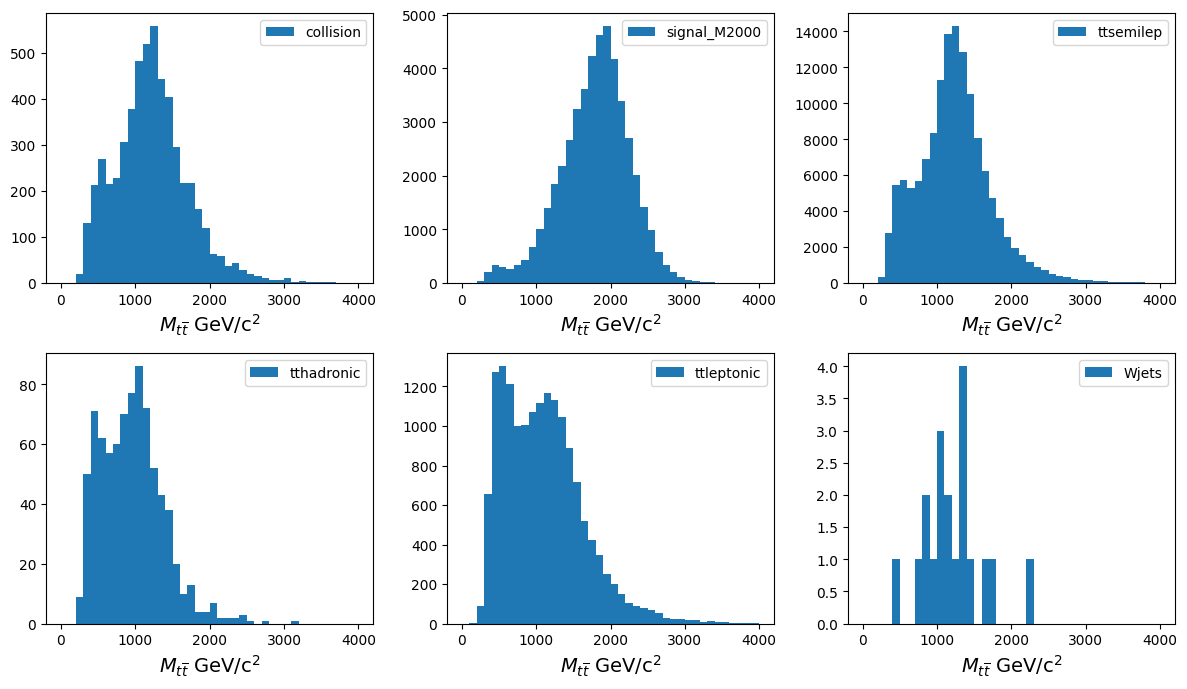

In [19]:
plt.figure(figsize=(12,7))

for i,dataset in enumerate(datasets):
    vals = data[dataset]['df']['mtt'].values
    
    plt.subplot(2,3,i+1)
    
    plt.hist(vals, bins=40, range=(0,4000), label=dataset)
    plt.xlabel(f'$M_{{t\overline{{t}}}}$ GeV/c$^2$', fontsize=14)
    
    plt.legend()
    
plt.tight_layout()

### Using `Hist`

The goal is to compare the stacked background histograms with the collision data, which can be done using vanilla matplotlib or ROOT. However, the [Hist](https://hist.readthedocs.io/en/latest/) library will be used for its beneficial features.

In [21]:
#Begin by creating an empty histogram to store and categorize data based on the dataset. 
#This histogram will have 40 bins and a range from 0 to 4000 for the `mtt` variable. 

h = Hist.new.Reg(40,0,4000, name='mtt', label=f'$M_{{t\overline{{t}}}}$ GeV/c$^2$')\
                .StrCat([], name="dataset", label="dataset", growth=True)\
                .Weight()

h

Hist(
  Regular(40, 0, 4000, name='mtt', label='$M_{t\\overline{t}}$ GeV/c$^2$'),
  StrCategory([], growth=True, name='dataset'),
  storage=Weight()) # Sum: WeightedSum(value=0, variance=0)

In [22]:
# Loop over the datasets
for dataset in datasets:
    
    print(dataset)

    # Extract the mtt values from our dictionary
    vals = data[dataset]['df']['mtt'].values

    # Fill the histogram and label by dataset
    h.fill(mtt=vals, dataset=dataset) 

collision
signal_M2000
ttsemilep
tthadronic
ttleptonic
Wjets


In [23]:
# This is a hypersimple representation of what is in the histogram
h

Hist(
  Regular(40, 0, 4000, name='mtt', label='$M_{t\\overline{t}}$ GeV/c$^2$'),
  StrCategory(['collision', 'signal_M2000', 'ttsemilep', 'tthadronic', 'ttleptonic', 'Wjets'], growth=True, name='dataset'),
  storage=Weight()) # Sum: WeightedSum(value=207679, variance=207679) (WeightedSum(value=207782, variance=207782) with flow)

With everything now in the histogram object, the background datasets can be quickly stacked and compared to the data.

/home/acer/.local/lib/python3.10/site-packages/hist/basehist.py:406: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


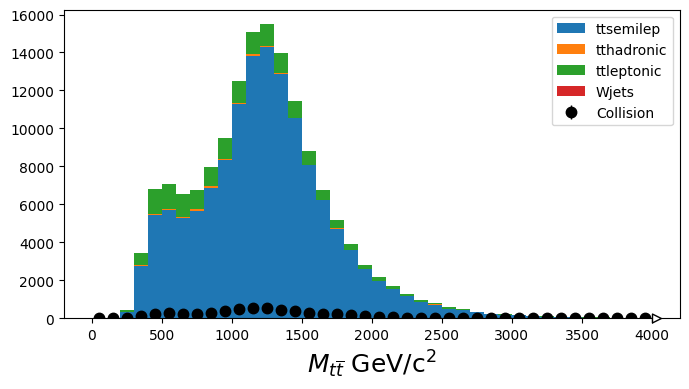

In [24]:
plt.figure(figsize=(7,4))

# Stack the background datasets
h[:,background_datasets].stack('dataset')[:].project('mtt').plot(stack=True, histtype="fill")

# Overlay the collision datasets
h[:,collision_datasets].project('mtt').plot(histtype="errorbar", color='k', markersize=15, label='Collision')

# Increase the size of the x-axis label
plt.xlabel(xlabel=plt.gca().get_xlabel(), fontsize=18);

# Draw a legend
plt.legend()

plt.tight_layout()
plt.savefig('mtt_00.png')

The MC samples haven't been weighted appropriately, as more MC data is generated than expected in the actual data. To address this:

* Determine the integrated luminosity ($\mathcal{L}$) for the collision data:
    * 16400 inverse picobarns
* Identify the cross section ($\sigma$) for each sample.
* Find the number of events generated for each sample.

Then, calculate the weight for each background sample using:

$$\textrm{weight} = \frac{\mathcal{L} \times \sigma}{N_{gen}}$$

For the signal, assume a cross section of 1 picobarn and use the inference procedure to determine the optimal value.

For `ttbar` backgrounds, start with the production cross section for top/antitop production (831.76) and scale by the probability of the W's decaying hadronically, leptonically, or in a combination.

Assign a weight of 1 to the collision data.

Calculate these weights for each dataset and store them in the `data` dictionary.

In [25]:
# Define the integrated luminosity for the collision data in inverse picobarns.
integrated_luminosity = 16400 # inverse picobarns

# Define the production cross section for ttbar in picobarns.
ttbar_production_xsec = 831.76 # picobarns


# Set the cross sections for various datasets.
data['Wjets']['xsec'] = 61526.7
data['ttsemilep']['xsec'] = ttbar_production_xsec*0.438
data['tthadronic']['xsec'] = ttbar_production_xsec*0.457
data['ttleptonic']['xsec'] = ttbar_production_xsec*0.105
data['signal_M2000']['xsec'] = 1 # Assume 1 pb


for dataset in [signal_datasets] + background_datasets:
    
    N_gen = data[dataset]['N_gen']
    
    xsec = data[dataset]['xsec']

    # Calculate the weight for the current dataset using the formula:
    weight = integrated_luminosity * xsec / N_gen

    # Store the calculated weight in the data dictionary for the current dataset.
    data[dataset]['weight'] = weight

# Assign a weight of 1 to the collision dataset.
data['collision']['weight'] = 1

In [26]:
# Print them out 
for dataset in datasets:
    w = data[dataset]['weight']
    
    print(f'{dataset:20s}  {w:.2f}')

collision             1.00
signal_M2000          0.03
ttsemilep             0.04
tthadronic            0.06
ttleptonic            0.03
Wjets                 12.46


Redefine the Hist histograms and refill them using the calculated weights. 

In [27]:
# Define a new histogram with 40 bins and range from 0 to 4000
# Include a weight axis to account for event weights
h = Hist.new.Reg(40,0,4000, name='mtt', label=f'$M_{{t\overline{{t}}}}$ GeV/c$^2$')\
                .StrCat([], name="dataset", label="dataset", growth=True)\
                .Weight()

for dataset in datasets:
    print(dataset)

    # Extract the 'mtt' values and the corresponding weight for the current dataset.
    vals = data[dataset]['df']['mtt'].values
    weight = data[dataset]['weight']

    # Fill the histogram with the 'mtt' values, dataset name, and weight.
    h.fill(mtt=vals, dataset=dataset, weight=weight) 

collision
signal_M2000
ttsemilep
tthadronic
ttleptonic
Wjets


The same plot can now be created.

/home/acer/.local/lib/python3.10/site-packages/hist/basehist.py:406: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


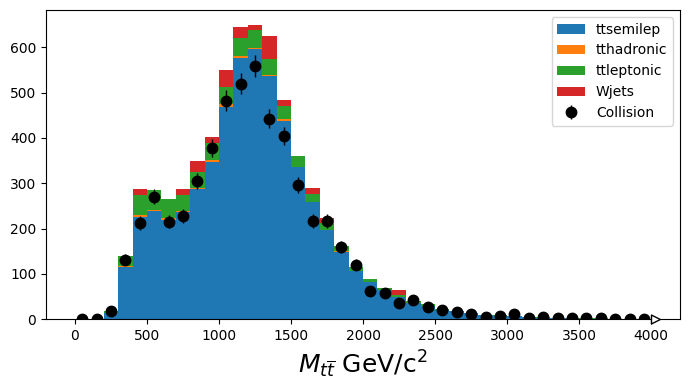

In [29]:
plt.figure(figsize=(7,4))

# Stack the background datasets
h[:,background_datasets].stack('dataset')[:].project('mtt').plot(stack=True, histtype="fill")

# Overlay the collision datasets
h[:,collision_datasets].project('mtt').plot(histtype="errorbar", color='k', markersize=15, label='Collision')

# Increase the size of the x-axis label
plt.xlabel(xlabel=plt.gca().get_xlabel(), fontsize=18);

# Draw a legend
plt.legend()

plt.tight_layout()
plt.savefig('mtt_01.png')

Overlay the signal to observe where it would manifest.

/home/acer/.local/lib/python3.10/site-packages/hist/basehist.py:406: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


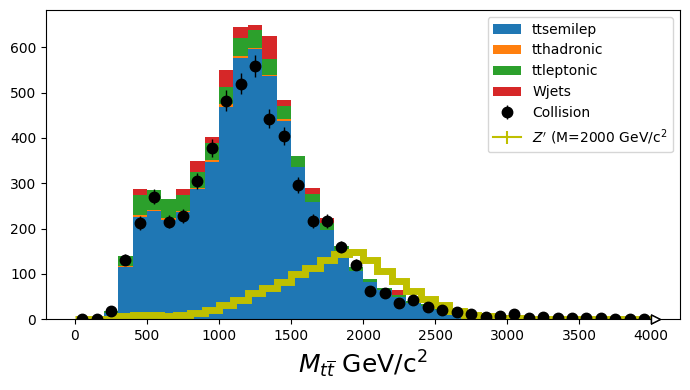

In [30]:
plt.figure(figsize=(7,4))

# Stack the background datasets
h[:,background_datasets].stack('dataset')[:].project('mtt').plot(stack=True, histtype="fill")

# Overlay the collision datasets
h[:,collision_datasets].project('mtt').plot(histtype="errorbar", color='k', markersize=15, label='Collision')

# Overlay the signal hypothesis
h[:,signal_datasets].project('mtt').plot(color='y', lw=5, label=f"$Z'$ (M=2000 GeV/c$^2$")

# Increase the size of the x-axis label
plt.xlabel(xlabel=plt.gca().get_xlabel(), fontsize=18);

# Draw a legend
plt.legend()

plt.tight_layout()
plt.savefig('mtt_02.png')


From this, several observations can be made:

- Scaling the backgrounds appropriately models the collision data quite well.
- The backgrounds primarily originate from the semileptonic decays of top/antitop pairs.
- The signal exhibits a different peak compared to the background.
- No *obvious* signal is present.